# Pulse Level Learning

In this notebook, we will train a reinforcement learning agent to learn pulse level control of a quantum system. The configuration is drawn from two dedicated yaml files respectively describing the quantum environment and the agent. The quantum environment is a `QuantumEnvironment` object, which is a subclass of `gym.Env ` and is designed to be compatible with standard RL libraries. The agent on the other hand, is specifically hard coded for our need because of the need to be able to send to the same resource (the Estimator primitive) a batch of quantum circuits (in contrast with usual RL frameworks where actions can be evaluated in parallel).

In [1]:
%matplotlib inline
from pulse_config import (
    q_env_config as pulse_q_env_config,
    circuit_context,
)
from quantumenvironment import QuantumEnvironmentV2
from context_aware_quantum_environment import ContextAwareQuantumEnvironmentV2
from gymnasium.wrappers import RescaleAction, ClipAction
from qiskit.circuit import QuantumCircuit
from helper_functions import simulate_pulse_schedule
from qiskit.quantum_info import Operator, Statevector
from qiskit import pulse
import numpy as np

2024-05-31 12:38:11,235 - qm - INFO     - Starting session: e42ededd-03d9-4d38-a7f7-f52d939e348b
Runtime Options: {'optimization_level': 0, 'resilience_level': None, 'max_execution_time': None, 'execution': {'init_qubits': True, 'rep_delay': None}, 'resilience': {'measure_mitigation': None, 'measure_noise_learning': {'num_randomizations': None, 'shots_per_randomization': None}, 'zne_mitigation': False, 'zne': {'noise_factors': None, 'extrapolator': None}, 'pec_mitigation': False, 'pec': {'max_overhead': None, 'noise_gain': None}, 'layer_noise_learning': {'max_layers_to_learn': None, 'shots_per_randomization': None, 'num_randomizations': None, 'layer_pair_depths': None}}, 'environment': {'log_level': 'WARNING', 'job_tags': None}}
Circuit context: 
global phase: π
                                                                       »
    ancilla_0 -> 0 ────────────────────────────────────────────────────»
                                                                       »
    anci

In [2]:
use_context = True

if use_context:
    q_env = ContextAwareQuantumEnvironmentV2(
        pulse_q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironmentV2(pulse_q_env_config)
# from qiskit.primitives import Estimator
# q_env.estimator = Estimator()
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

In [3]:
from qiskit.visualization import plot_gate_map
from qiskit.transpiler import Target

q_env.backend.target.operations
# plot_gate_map(q_env.backend)

[Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 qiskit.circuit.controlflow.if_else.IfElseOp,
 qiskit.circuit.controlflow.switch_case.SwitchCaseOp,
 qiskit.circuit.controlflow.for_loop.ForLoopOp,
 Delay(duration=t[unit=dt]),
 Instruction(name='ecr_cal0', num_qubits=2, num_clbits=0, params=[ParameterVectorElement(a_0[0]), ParameterVectorElement(a_0[1]), ParameterVectorElement(a_0[2]), ParameterVectorElement(a_0[3])]),
 Instruction(name='ecr_cal1', num_qubits=2, num_clbits=0, params=[ParameterVectorElement(a_1[0]), ParameterVectorElement(a_1[1]), ParameterVectorElement(a_1[2]

In [4]:
from helper_functions import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd() / file_name

agent_config = load_from_yaml_file(file_location)

In [5]:
from ppo import CustomPPO

ppo_agent = CustomPPO(agent_config, rescaled_env)

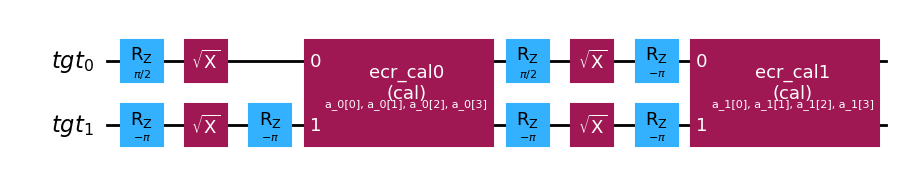

In [6]:
circuit = q_env.circuits[1]
circuit.draw("mpl")

In [7]:
ppo_agent.train(
    total_updates=300, print_debug=False, num_prints=10, clear_history=False
)

  0%|          | 0/300 [00:00<?, ?it/s]/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/base_q_env.py:745: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]


Sending Estimator job...
2024-05-31 13:41:00 INFO ping/pong timed out - goodbye
2024-05-31 13:41:20 INFO [Errno 8] nodename nor servname provided, or not known - goodbye
2024-05-31 13:41:21 INFO [Errno 8] nodename nor servname provided, or not known - goodbye
2024-05-31 13:41:23 INFO [Errno 8] nodename nor servname provided, or not known - goodbye
2024-05-31 13:41:27 INFO [Errno 8] nodename nor servname provided, or not known - goodbye
2024-05-31 13:41:35 INFO [Errno 8] nodename nor servname provided, or not known - goodbye


base_runtime_job._start_websocket_client:WARNING:2024-05-31 13:41:35,129: An error occurred while streaming results from the server for job cscn8sbdape00085vyw0:
Traceback (most recent call last):
  File "/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 314, in _start_websocket_client
    self._ws_client.job_results()
  File "/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/api/clients/base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/Users/arthuro

2024-05-31 13:41:35 INFO Retrying (PostForcelistRetry(total=4, connect=2, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x359e7c550>: Failed to resolve 'api.quantum.ibm.com' ([Errno 8] nodename nor servname provided, or not known)")': /runtime/jobs/cscn8sbdape00085vyw0?exclude_params=true
2024-05-31 13:41:36 INFO Retrying (PostForcelistRetry(total=3, connect=1, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x380dd6c50>: Failed to resolve 'api.quantum.ibm.com' ([Errno 8] nodename nor servname provided, or not known)")': /runtime/jobs/cscn8sbdape00085vyw0?exclude_params=true
2024-05-31 13:41:38 INFO Retrying (PostForcelistRetry(total=2, connect=0, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x380bfdf10>: Failed to resolve '

  0%|          | 0/300 [1:02:39<?, ?it/s]


RequestsApiError: 'HTTPSConnectionPool(host=\'api.quantum.ibm.com\', port=443): Max retries exceeded with url: /runtime/jobs/cscn8sbdape00085vyw0?exclude_params=true (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x380cd3410>: Failed to resolve \'api.quantum.ibm.com\' ([Errno 8] nodename nor servname provided, or not known)"))'

In [ ]:
from base_q_env import GateTarget
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
if q_env.benchmark_cycle != 0:
    fidelity_range = np.arange(0, n_epochs, q_env.benchmark_cycle)
    plt.plot(
        fidelity_range,
        np.array(q_env.fidelity_history),
        label="Average Fidelity (mean over batch)",
    )
plt.plot(mean_rewards / 2, label=f"Mean Batch Rewards, max: {max_mean}")

plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name if isinstance(q_env.target, GateTarget) else ''} Learning Curve"
)
plt.legend()
plt.show()

In [ ]:
print("Optimal action", q_env.optimal_action)
print("Best fidelity:", np.max(q_env.fidelity_history))

In [ ]:
cal = q_env.backend.target.get_calibration("x", (0,))
from helper_functions import simulate_pulse_schedule
from qiskit.circuit.library import CXGate, HGate, RZGate, ECRGate
from qiskit.quantum_info import average_gate_fidelity, Operator, Statevector

data = simulate_pulse_schedule(q_env.backend, cal)

print(data)

In [ ]:
# Update the gate calibration in the backend target and retrieve the calibration
optimal_calibration = q_env.update_gate_calibration()
q_env.backend.target.get_calibration("x", (0,)).draw()

In [ ]:
from helper_functions import simulate_pulse_schedule
from qiskit.circuit.library import CXGate, HGate, RZGate, ECRGate
from qiskit.quantum_info import average_gate_fidelity, Operator, Statevector

data = simulate_pulse_schedule(
    q_env.backend,
    optimal_calibration,
    target_unitary=Operator(q_env.target["gate"]),
)

print(data)

In [ ]:
# Testing gate in a quantum circuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw("mpl")

basic_simulator = BasicSimulator()
basic_result = basic_simulator.run(qc).result()

pulse_circ = transpile(qc, q_env.backend)
q_env.backend.options.shots = 1000
pulse_results = q_env.backend.run(pulse_circ).result()

print("BasicProvider: ", basic_result.get_counts())
print("Custom Backend:", pulse_results.get_counts())

In [ ]:
pulse_circ.draw("mpl")

In [ ]:
# Testing the pulse schedule
from qiskit import schedule

pulse_schedule = schedule(
    pulse_circ.remove_final_measurements(inplace=False), q_env.backend
)
pulse_schedule.draw()

In [ ]:
# Testing the pulse schedule
pulse_sim_results = simulate_pulse_schedule(
    q_env.backend,
    pulse_schedule,
    target_unitary=Operator(pulse_circ.remove_final_measurements(inplace=False)),
    target_state=(Statevector.from_label("00") + Statevector.from_label("11"))
                 / np.sqrt(2),
)
print(pulse_sim_results)

In [ ]:
new_circ = transpile(
    pulse_circ.remove_final_measurements(inplace=False),
    q_env.backend,
    scheduling_method="asap",
)
new_circ.draw("mpl")

In [ ]:
new_circ.op_start_times

In [ ]:
instruction_list = []
for instruction in new_circ.data:
    instruction_list.append(instruction.operation.name)
instruction_list